In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Kaggle_Quora_Project/train_csv.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Kaggle_Quora_Project/train_csv.zip
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def read_data(filename,encoding="utf8"):
    df = pd.read_csv(filename)
    # Drop null values
    df.dropna(inplace=True)
    df.reset_index(drop=True,inplace=True)
    print("\nNumber of records:",len(df))
    return df

df = read_data("train.csv")


Number of records: 404287


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.0 MB/s eta 0:00:00


In [ ]:
import re
import contractions
import string

def preprocess_data(text):
    # conver to string
    text = str(text)
    # lowercase
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove hashtags
    text = re.sub(r'#(\w+)','',text)
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove links if any
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # remove multiple spaces
    text = ' '.join(text.split())

    return text


In [ ]:
new_df = df.sample(30000)
new_df_copy = new_df.copy() # Create a copy of the original dataframe
new_df_copy.loc[:,"question1"] = new_df_copy["question1"].apply(preprocess_data)
new_df_copy.loc[:,"question2"] = new_df_copy["question2"].apply(preprocess_data)
new_df_copy.head()


,id,qid1,qid2,question1,question2,is_duplicate
263023,263025,379498,346618,why did hindi is not national language of india,should hindi be made the national language of ...,0
187725,187726,30859,74700,can get pregnant the day after my period ends,can get pregnant days after my period started,1
139283,139284,221602,221603,what is the best place for iphone screen repai...,how can get an iphone with water damage repair...,0
364316,364319,494379,494380,what is the work of hr professional in company...,what companies are the best places to work for...,0
53937,53937,95271,95272,what is retailnexts business model,what is iodine business model,0


In [ ]:
new_df_copy['is_duplicate'].value_counts()

0    18951
1    11049
Name: is_duplicate, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
df_train,df_dev = train_test_split(new_df_copy,
                                   test_size=0.2,
                                   random_state=42)

print("Training data shape:",df_train.shape)
print("Dev data shape:",df_dev.shape)

Training data shape: (24000, 6)
Dev data shape: (6000, 6)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_train['question1']+' '+df_train['question2'])
dev_tfidf = tfidf.transform(df_dev['question1']+' '+df_dev['question2'])

train_tfidf.shape,dev_tfidf.shape

((24000, 24061), (6000, 24061))

In [ ]:
labels = df_train['is_duplicate']
labels.shape

(24000,)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

rf = RandomForestClassifier()
rf.fit(train_tfidf, labels)
y_pred = list(rf.predict(dev_tfidf))
accuracy_score(df_dev['is_duplicate'], y_pred)

0.7528333333333334

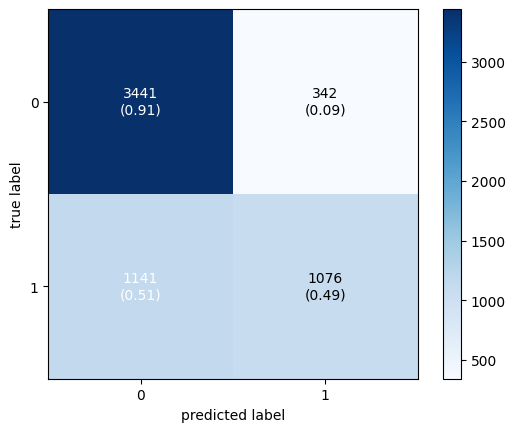

In [ ]:
# Confusion Matrix
cm = confusion_matrix(df_dev['is_duplicate'],y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
# Classification Report

print("\t\tClassification Report\n\n:",classification_report(df_dev['is_duplicate'],y_pred))


		Classification Report

:               precision    recall  f1-score   support

           0       0.75      0.91      0.82      3783
           1       0.76      0.49      0.59      2217

    accuracy                           0.75      6000
   macro avg       0.75      0.70      0.71      6000
weighted avg       0.75      0.75      0.74      6000



In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_tfidf,labels)
y_pred = list(xgb.predict(dev_tfidf))
accuracy_score(df_dev['is_duplicate'],y_pred)

0.732

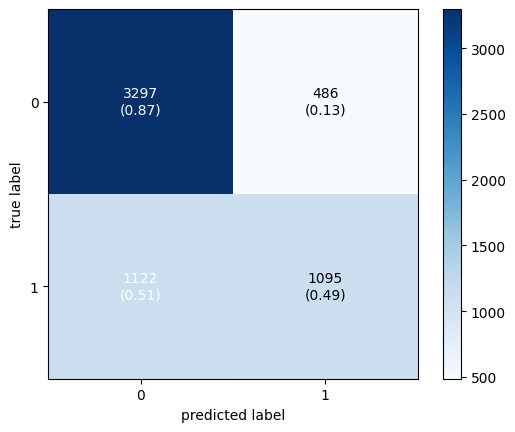

In [ ]:
# Confusion Matrix
cm = confusion_matrix(df_dev['is_duplicate'],y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
# Classification Report

print("\t\tClassification Report\n\n:",classification_report(df_dev['is_duplicate'],y_pred))


		Classification Report

:               precision    recall  f1-score   support

           0       0.75      0.87      0.80      3783
           1       0.69      0.49      0.58      2217

    accuracy                           0.73      6000
   macro avg       0.72      0.68      0.69      6000
weighted avg       0.73      0.73      0.72      6000

